#  第13堂 CIFAR 建模練習_CNN_加L2_epoch200

In [1]:
#檢查 GPU
import tensorflow as tf
# print('gpu',tf.test.is_gpu_available())
# import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

def lr_schedule(epoch):#lrate為學習率(learning rate)，用epoch決定學習率
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
num_classes = 10
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)
 
weight_decay = 1e-4#正則化
model = Sequential()#我們用keras線性堆疊數個簡單的模型
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))#卷積層與正則化
model.add(Activation('relu'))#激活函數
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))#最大池化層，降低模型的計算成本和過擬合的風險

#32,64,128是設置不同深度，逐步提取和學習輸入圖像的不同層次的特徵，
#例如:較低層次（32個卷積核）的卷積層主要捕捉圖像的局部特徵，如邊緣、紋理等。較高層次（128個卷積核）的卷積層則能夠學習到更抽象的特徵，如圖像的整體結構和輪廓
#這樣的設計有助於模型在訓練過程中逐步學習到圖像的不同層次，提高其分類或預測的準確度。
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4)) # 百分比40%的神經元輸出直接當成 0 丟棄不用, 避免過度預測 overfitting 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()
 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0

In [4]:
#data augmentation
#ImageDataGenerator是Keras提供的圖像數據增強工具，可以動態地生成增強過的圖像數據，以擴充訓練集，改善模型的泛化能力。
datagen = ImageDataGenerator(
    rotation_range=15,#隨機旋轉圖像範圍（0-15度）
    width_shift_range=0.1,#水平和垂直方向上隨機移動圖像的比例（相對於總寬度或高度的比例）
    height_shift_range=0.1,
    horizontal_flip=True,#隨機水平翻轉圖像
    )
datagen.fit(x_train)#通過fit函數將數據增強器擬合到訓練集上，這將計算相應的統計參數（例如平均值和標準差），並將它們應用於數據增強過程中。
 
#training
batch_size = 64#每批樣本數量
epochs = 200 #訓練的次數
# opt_rms = keras.optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])#編譯模型，設置損失函數、優化器和評估指標

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\#通過 flow 函數生成增強後的批次數據
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\#每個 epoch 的步數，通常設置為訓練集大小除以批次大小
                    verbose=1,validation_data=(x_test,y_test),#用於驗證資料
                    callbacks=[LearningRateScheduler(lr_schedule)])#設置學習率的調度器，回調函數。
#save to disk

model.save('cifar10_keras_model_L2_0520_200.h5') 
 
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)


Epoch 1/200
781/781 [==============================] - 22s 28ms/step - loss: 1.0322 - accuracy: 0.6532 - val_loss: 1.0046 - val_accuracy: 0.6875
Epoch 2/200
781/781 [==============================] - 22s 28ms/step - loss: 0.9147 - accuracy: 0.7029 - val_loss: 0.9965 - val_accuracy: 0.6871
Epoch 3/200
781/781 [==============================] - 22s 28ms/step - loss: 0.8447 - accuracy: 0.7325 - val_loss: 0.8093 - val_accuracy: 0.7549
Epoch 4/200
781/781 [==============================] - 22s 28ms/step - loss: 0.7902 - accuracy: 0.7538 - val_loss: 0.8265 - val_accuracy: 0.7536
Epoch 5/200
781/781 [==============================] - 22s 28ms/step - loss: 0.7580 - accuracy: 0.7668 - val_loss: 0.8090 - val_accuracy: 0.7701
Epoch 6/200
781/781 [==============================] - 22s 28ms/step - loss: 0.7330 - accuracy: 0.7795 - val_loss: 0.7568 - val_accuracy: 0.7752
Epoch 7/200
781/781 [==============================] - 22s 28ms/step - loss: 0.7064 - accuracy: 0.7897 - val_loss: 0.7451 - val_ac

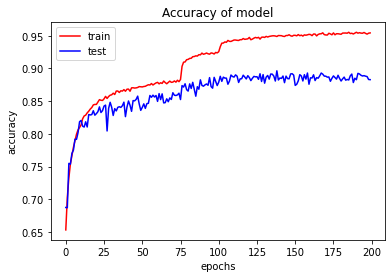

In [5]:
plt.title('Accuracy of model')
plt.plot(history.history['accuracy'],color='red')
plt.plot(history.history['val_accuracy'],color='blue')
plt.legend(['train','test'] , loc='upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Text(0, 0.5, 'accuracy')

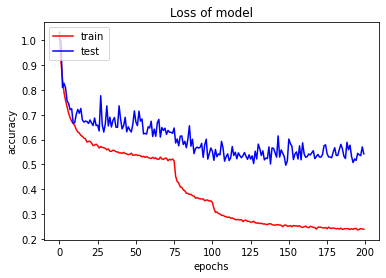

In [6]:
plt.title('Loss of model')
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['val_loss'],color='blue')
plt.legend(['train','test'] , loc='upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [7]:
weight_decay = 1e-4
weight_decay

0.0001

In [3]:
# 載入模型 load_model
import tensorflow as tf
print('1.請先載入自己的模型')
model = tf.keras.models.load_model('cifar10_keras_model_L2_0520_200.h5')
model.summary()

1.請先載入自己的模型
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 

In [4]:
print(x_test.shape, y_test.shape)

(10000, 32, 32, 3) (10000, 10)


In [5]:
# 測試集的預測值
preds=model.predict(x_test)
y_hat = np.argmax(preds,axis=1)
y_hat



array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [7]:
# 混淆矩陣/交叉表
import pandas as pd
pd.crosstab(y_test.argmax(axis=1),y_hat,rownames=['label'],colnames=['predict'])


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,880,9,29,8,12,0,3,4,38,17
1,3,952,0,0,0,0,2,0,6,37
2,23,1,844,13,38,15,42,14,4,6
3,6,6,29,704,53,75,79,17,10,21
4,2,2,6,8,927,8,32,13,0,2
5,2,4,21,92,37,779,29,28,4,4
6,4,2,12,5,7,4,958,0,2,6
7,6,1,6,10,39,15,4,914,1,4
8,31,9,1,4,3,0,5,2,926,19


In [8]:
# 精準度 召回率  調和平均值 F-score
from  sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), y_hat))


              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1000
           1       0.94      0.95      0.94      1000
           2       0.89      0.84      0.87      1000
           3       0.83      0.70      0.76      1000
           4       0.83      0.93      0.88      1000
           5       0.87      0.78      0.82      1000
           6       0.83      0.96      0.89      1000
           7       0.92      0.91      0.92      1000
           8       0.93      0.93      0.93      1000
           9       0.89      0.94      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

